# Assignment-1: Camera Calibration 
### Done By: Abhinav Gupta, 20171059
Implementing and comparing two very popular camera calibration techniques: DLT and Zhang's method. We also test the quality of the parameters estimated from these calibration methods. 

## Direct Linear Transform
### Implementation
- We perform DLT based calibration on a given image and estimate the camera parameters. 
- We use 20-30 different points on different planes and report the projection, camera, rotation matrices and the projection center.  
- The given image is 'calib-object.jpg'. We need to manually estimate the image coordinates by referring to 'calib-object-legend.jpg' for world measurements. 

- First, let's import all the libraries we need. 

In [40]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg
import glob
import math
import random

- We need to perform camera calibration on 'calib-object.jpg'

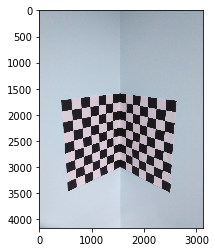

In [2]:
img1 = cv2.imread('./data/calib-object.jpg')
plt.imshow(img1)

### 3D - 2D correspondences - Control Points
- First, we manually compute the 2D-3D correspondences by plotting the image, and moving the cursor around to get the pixel coordinates.  
`img = plt.imread('calib-object.jpg')` \
`plt.imshow(img)` \ 


We choose the following control points (computed manually), and their corresponding 2D pixel locations.
- (0,0,0) - (1549, 1599)
- (0,28,0) - (1547, 1763)
- (56,0,0) - (1797, 1625)
- (56,28,0) - (1793, 1807)
- (56,84,0) - (1785, 2156)
- (84,84,0) - (1918, 2196)
- (112,56,0) - (2069, 2051)
- (112,84,0) - (2061, 2233)
- (84,56,0) - (1928, 2015)
- (84,112,0) - (1915, 2366)
- (0,28,28) - (1413, 1781)
- (0,28,56) - (1280, 1807)
- (0,56,28) - (1415, 1958)
- (0,56,56) - (1283, 1981)
- (0,56,84) - (1139, 2013)
- (0,56,112) - (990, 2041)
- (0,112,0) - (1541, 2251)
- (0,112,28) - (1420, 2287)
- (0,112,56) - (1292, 2320)
- (0,112,84) - (1149, 2356)
- (0,112,112) - (1005, 2401)

Let's make two arrays: worldcoo and imagecoo, that contain the control points and their 2D locations respectively. 

In [3]:
worldcoo = [ (0,0,0), (0,28,0), (56,0,0), (56,28,0), (56,84,0), (84,84,0), (112,56,0),
             (112,84,0), (84,56,0), (84,112,0), (0,28,28), (0,28,56), (0,56,28), (0,56,56), 
             (0,56,84), (0,56,112), (0,112,0), (0,112,28), (0,112,56), (0,112,84), (0,112,112) 
           ]

imagecoo = [ (1549, 1599), (1547, 1763), (1797, 1625), (1793, 1807), (1785, 2156), (1918, 2196),
             (2069, 2051), (2061, 2233), (1928, 2015), (1915, 2366), (1413, 1781), (1280, 1807),
             (1415, 1958), (1283, 1981), (1139, 2013), (990, 2041), (1541, 2251), (1420, 2287),
             (1292, 2320), (1149, 2356), (1005, 2401)
           ]

### Building the DLT Matrix (2n x 12)
- Here, n=21 because we choose 21 points, and we get 2 (1x12) vectors corresponding to each point. 
- So each point two rows associated with it, and there are totally 21 points, hence 42 rows. 
- Therefore, our DLT matrix will be of dimensions (42x12)

- The `create_row1` function returns the first (1x12) vector for a 3D world point and its corresponding image coordinates.

In [4]:
def create_row1(world, image):
    x = []
    x = np.array(x)
    
    e1 = -1*world[0]
    e2 = -1*world[1]
    e3 = -1*world[2]
    
    x = np.append(x, (e1,e2,e3))
    x = np.append(x, (-1,0,0,0,0))
    
    e9 = image[0]*world[0] 
    e10 = image[0]*world[1] 
    e11 = image[0]*world[2] 
    e12 = image[0]
    x = np.append(x, (e9,e10,e11,e12))
    return x

- Similarly, - The `create_row2` function returns the second (1x12) vector for the 3D world point and its corresponding image coordinates.

In [5]:
def create_row2(world, image):
    y = []
    y = np.array(y)
    y = np.append(y, (0,0,0,0))
    
    e5 = -1*world[0]
    e6 = -1*world[1]
    e7 = -1*world[2]
    y = np.append(y, (e5,e6,e7,-1))
    
    e9 = image[1]*world[0] 
    e10 = image[1]*world[1] 
    e11 = image[1]*world[2] 
    e12 = image[1]
    y = np.append(y, (e9,e10,e11,e12))
    return y

- We take all the 21 points one by one, create the (2x12) matrix for each, and stack them on top of each other to obtain the final DLT matrix of dimensions (2nx12)

In [7]:
dlt_mat = []
dlt_mat = np.array(dlt_mat)

for i in range(0,21):
    row1 = create_row1(worldcoo[i], imagecoo[i])
    row2 = create_row2(worldcoo[i], imagecoo[i])
    dlt_mat = np.append(dlt_mat, row1)
    dlt_mat = np.append(dlt_mat, row2)
print(dlt_mat.shape)

(504,)


- We get a (504x1) vector, which is correct, as we had 21 points and each point yielded (2x12) = 24 values. So 24x21 = 504 values. 
- We need to reshape this into a (2nx12) = (42x12) matrix, where each couple of rows correspond to a single world point.

In [8]:
dlt_mat = dlt_mat.reshape(42, 12)
print(dlt_mat.shape)

(42, 12)


## Solving the linear system of equations by SVD
- Now that we have our DLT matrix, we need to solve the linear system of equations to obtain the camera parameters such that Mp = 0, where M is `dlt_mat'
- We do this by applying singular value decomposition (SVD) to `dlt_mat`. 
- `M = U S V.T` 
- The solution is the last column of V

In [16]:
U, S, V = np.linalg.svd(dlt_mat)

In [36]:
P = V[-1,:]
P = np.array(P)
P = np.reshape(P,(3,4))
with np.printoptions(suppress=True): print('The Projection matrix is \n',P)

The Projection matrix is 
 [[-0.00106739 -0.00031384  0.00275453 -0.69612992]
 [ 0.00060642 -0.00311488  0.00049928 -0.71790235]
 [ 0.00000053 -0.00000021  0.00000047 -0.00045042]]


In [39]:
H = P[:,:3]
K, R = linalg.rq(H)
K = K/K[2,2]
t = np.dot(-1*np.linalg.inv(H), P[:,3])
with np.printoptions(suppress=True): print('The Intrinsic matrix is \n',K)
with np.printoptions(suppress=True): print('The Rotation matrix is \n',R)
with np.printoptions(suppress=True): print('The Translation matrix is \n',t)

The Intrinsic matrix is 
 [[ 3747.98123092    16.40665733  1436.9755183 ]
 [   -0.         -3736.05884976  2209.63419683]
 [   -0.            -0.             1.        ]]
The Rotation matrix is 
 [[ 0.66194001  0.00873237 -0.74950595]
 [-0.20678851 -0.95899906 -0.19380223]
 [-0.72046786  0.28327467 -0.63299409]]
The Translation matrix is 
 [447.8469299  -76.35450855 417.56436528]


## Zhang's Method
We use the checkerboard images given to us and perform camera calibration using Zhang's method. 

In [8]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = ['./data/IMG_5456.jpg', './data/IMG_5457.jpg', './data/IMG_5458.jpg', './data/IMG_5459.jpg', 
          './data/IMG_5460.jpg', './data/IMG_5461.jpg', './data/IMG_5462.jpg', './data/IMG_5463.jpg', 
          './data/IMG_5464.jpg', './data/IMG_5465.jpg', './data/IMG_5466.jpg', './data/IMG_5467.jpg',
          './data/IMG_5468.jpg', './data/IMG_5469.jpg', './data/IMG_5470.jpg'
         ]
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

In [ ]:
print(objp)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
#         cv2.imshow('img',img)


[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]]


In [41]:
# Function to convert the Rotation Matrix into the Euler Angles
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R